## Exercice 2.4

### Téléchargement, visualisation et préparation des données

In [39]:
import pandas as pd

url = "https://zenodo.org/record/3271358/files/multilingual_wikidata_translation_flow.csv"
dataframe = pd.read_csv(url)

print("Aperçu des données :")
print(dataframe.head())
print(f"Nombre de lignes: {len(dataframe)}")

Aperçu des données :
              timestamp property language         type
0  2013-10-26T16:45:20Z     P999       en        label
1  2013-10-26T16:45:20Z     P999       en  description
2  2013-10-26T18:16:05Z     P999       de        label
3  2013-10-27T02:55:15Z     P999       pt        label
4  2013-10-27T02:55:18Z     P999       fr        label
Nombre de lignes: 241346


Nombre de lignes après nettoyage : 238793
Distribution des langues :
language
en          15724
uk          14658
fr          13048
ar          10987
nl           8990
            ...  
kea             1
khw             1
ki              1
kiu             1
language        1
Name: count, Length: 426, dtype: int64


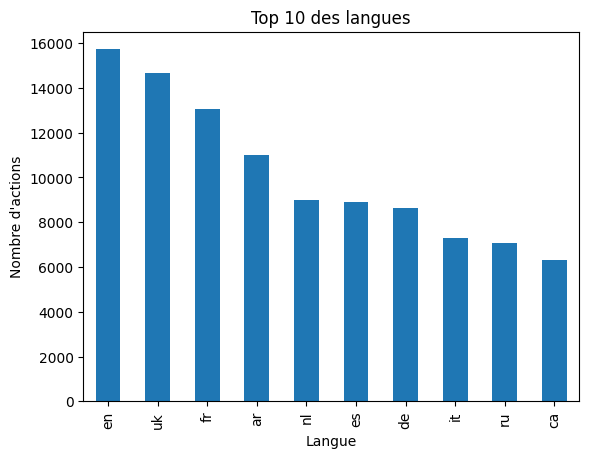

In [40]:
import matplotlib.pyplot as plt
dataframe = dataframe.drop_duplicates()
dataframe = dataframe.dropna()

print(f"Nombre de lignes après nettoyage : {len(dataframe)}")

# Distribution des langues
langue_counts = dataframe['language'].value_counts()
print("Distribution des langues :")
print(langue_counts)

# Bar plot pour les langues
langue_counts.head(10).plot(kind='bar')
plt.title("Top 10 des langues")
plt.xlabel("Langue")
plt.ylabel("Nombre d'actions")
plt.show()


## Modélisation

### Création des séquences de langues

In [41]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encoder les langues
label_encoder = LabelEncoder()
dataframe['language_encoded'] = label_encoder.fit_transform(dataframe['language'])

# Création des séquences de langues
seq_length = 2  # On utilise les 2 langues précédentes pour prédire la suivante
sequences = []
next_languages = []

for i in range(len(dataframe) - seq_length):
    sequences.append(dataframe['language_encoded'].iloc[i:i+seq_length].values)  # Les langues précédentes
    next_languages.append(dataframe['language_encoded'].iloc[i+seq_length])  # La langue suivante

X = np.array(sequences)
y = np.array(next_languages)

In [42]:
print("Premières séquences X :")
print(X[:5])
print("Premières cibles y :")
print(y[:5]) 

Premières séquences X :
[[ 94  94]
 [ 94  79]
 [ 79 296]
 [296 109]
 [109 290]]
Premières cibles y :
[ 79 296 109 290 109]


In [43]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Dimensions des données d'entraînement : {X_train.shape}")

X_train_subset = X_train[:int(0.1 * len(X_train))]
y_train_subset = y_train[:int(0.1 * len(y_train))]


Dimensions des données d'entraînement : (191032, 2)


### Modèle

In [44]:
from tensorflow.keras import layers, models

vocab_size = 426  # Nombre de langues uniques
seq_length = 2  # Longueur des séquences d'entrée

model = models.Sequential()

model.add(layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=seq_length))

model.add(layers.ZeroPadding1D(padding=2))  # Si tu veux ajouter du padding

model.add(layers.Conv1D(256, 2, activation='relu', padding='same'))
model.add(layers.Conv1D(512, 2, activation='relu', padding='same')) 

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(vocab_size, activation='softmax'))  # Prédiction des langues

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\vpica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Entrainement 

In [45]:
history = model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=100, validation_data=(X_test, y_test))

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.1193 - loss: 4.3128 - val_accuracy: 0.2512 - val_loss: 3.4993
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2633 - loss: 3.4451 - val_accuracy: 0.2994 - val_loss: 3.3115
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3064 - loss: 3.2437 - val_accuracy: 0.3100 - val_loss: 3.2673
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3179 - loss: 3.1334 - val_accuracy: 0.3178 - val_loss: 3.2501
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3244 - loss: 3.0867 - val_accuracy: 0.3236 - val_loss: 3.2454
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3236 - loss: 3.0270 - val_accuracy: 0.3279 - val_loss: 3.2367
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.3361 - loss: 2.9568 - val_accuracy: 0.3284 - val_loss: 3.2495
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.3290 - loss: 2.9346 - val_a